# Ερώτημα 1

## Ζητούμενο 1

In [1]:
%matplotlib inline
%pylab inline

import os
import re
import numpy as np
from google.colab import drive
from PIL import Image
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn import metrics, svm
from sklearn.svm import SVR
from sklearn.metrics import classification_report

import pandas.util.testing as tm
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

!pip install python-resize-image
from resizeimage import resizeimage

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'DI/images/'

Mounted at /content/gdrive


In [3]:
def image_to_vector(image: np.ndarray) -> np.ndarray:
    """
    image: numpy array of shape (length, height, depth)
    Returns: a vector of shape (length x height x depth, 1) = (30000, 1)
    """
    length, height, depth = image.shape
    return image.reshape((length * height * depth, 1))


def loadImages(path):

  arr = np.empty((0,1), int)  # will be an array of image data size 30000*30
  for i in range(0,30000):    # first fill with zeros
      arr = np.append(arr, np.array([[0]]), axis=0)

  labels = list()
  imageNames = list()

  for filename in os.listdir(path):
    imageNames.append(filename)

    if filename[0]=="W":
      labels.append(0)
    elif filename[0]=="F":
      labels.append(1)
    else:
      labels.append(2)

    with open(path + '/' + filename, 'r+b') as f:
      with Image.open(f) as image:

        # img=mpimg.imread(f)
        # imgplot = plt.imshow(img)
        # plt.show()

        cover = resizeimage.resize_cover(image, [100, 100])
        cover.save(path + '/' + filename, image.format)

        # convert image to numpy array
        data = np.asarray(cover)

        actual = image_to_vector(data)

        arr = np.append(arr, actual.tolist(), axis=1)

        # img = Image.fromarray(data, 'RGB')
        # imgplot = plt.imshow(img)
        # plt.show()

  arr = np.delete(arr, 0, 1)
  return arr, labels, imageNames

Πίνακας Δεδομένων και labels

In [4]:
imAr, labels, imageNames = loadImages(base_dir)

imAr = np.array(imAr)
print("Image labels are:", labels)

print("type(imAr)", type(imAr))
print("imAr.shape", imAr.shape)

print(imAr)

Image labels are: [1, 2, 0, 0, 0, 2, 1, 2, 1, 1, 0, 0, 2, 2, 0, 1, 0, 2, 0, 1, 1, 0, 2, 2, 1, 1, 0, 2, 1, 2]
type(imAr) <class 'numpy.ndarray'>
imAr.shape (30000, 30)
[[ 58  57  68 ...  18 145 137]
 [ 78  63  68 ...   2 110 138]
 [115  35  78 ...  12  88  78]
 ...
 [103  38 218 ...   0  46  16]
 [ 83  39 224 ...  11  38   0]
 [ 33  31 236 ...  43  19  20]]


Check that all images have been resized

In [5]:
# for filename in os.listdir(base_dir):
#   image = Image.open(base_dir + '/' + filename)
#   print(filename,"has size", image.size)  # size in pixels as a 2-tuple (width, height)

## Ζητούμενο 2

In [6]:
def plotImage(x, y, im, ax):
  bb = Bbox.from_bounds(x,y,30,30)  
  bb2 = TransformedBbox(bb,ax.transData)
  bbox_image = BboxImage(bb2,
                      norm = None,
                      origin=None,
                      clip_on=False)

  Marker = plt.imread(im)
  bbox_image.set_data(Marker)
  ax.add_artist(bbox_image)


def PCADF(df):
  scaled_features = StandardScaler().fit_transform(df.values)
  df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(df.values)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

  return principalDf


def PCA_ImageSpaceVisualization(X): # X is the data array
  df = pd.DataFrame(data=X)
  df = df.T

  principalDf = PCADF(df)

  principalDf["Images"] = imageNames

  fig = plt.figure(figsize = (15,15))
  ax = fig.add_subplot(111)
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title('2 component PCA', fontsize = 20)

  for x, y , im in zip(principalDf["PC1"], principalDf["PC2"], principalDf["Images"]):
    plotImage(x, y, base_dir + im, ax)

  ax.set_ylim(-200,200)
  ax.set_xlim(-200,250)
  ax.grid()

  return

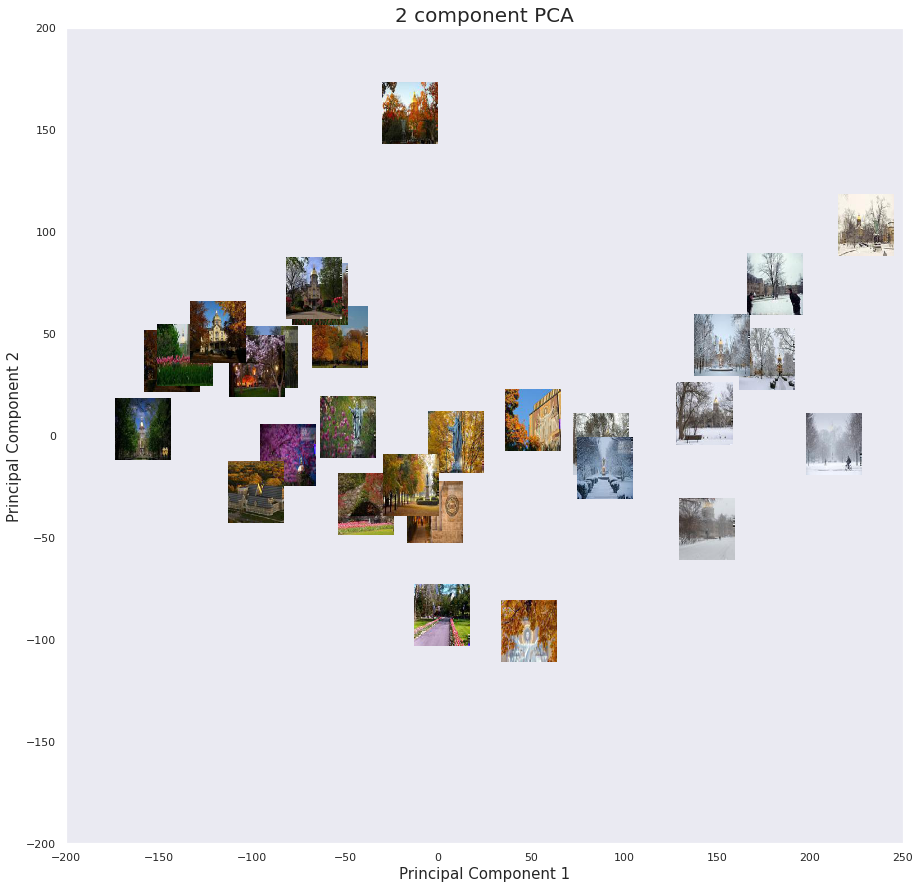

In [7]:
PCA_ImageSpaceVisualization(imAr)

##### 2.1

Η PCA είναι μια dimensionality-reduction μέθοδος που χρησιμοποιεί μόνο τα σημαντικότερα χαρακτηριστικά από τα δεδομένα για να τα συγκρίνει πιο εύκολα και γρήγορα και για να είναι ευκολότερη η οπτικοποίησή τους. Όσο πιο κοντά βρίσκονται δύο εικόνες μεταξύ τους στο plot, τόσο πιο πανομοιότυπες είναι με βάση τις δύο πρώτες κύριες συνιστώσες, ενώ όσο πιο μακριά βρίσκονται τόσο λιγότερο πανομοιότυπες είναι.
Τα συμπεράσματα αυτά γενικεύονται και για τον μεγάλης διάστασης αρχικό χώρο χαρακτηριστικών των εικόνων. Εφαρμόζοντας PCA δεν αλλοιώνονται τα χαρακτηριστικά των δεδομένων, αλλά μόνο απλοποιούνται. Αν κάναμε μια αντίστοιχη σύγκριση χρησιμοποιώντας όλα τα αρχικά features θα είχαμε ίδια και ίσως σαφέστερα αποτελέσματα όσον αφορά τις εικόνες, μόνο που θα απαιτούνταν εκτενέστερη και πιο αργή επεξεργασία.

##### 2.2
Οι χειμωνιάτικες εικόνες ομαδοποιούνται πιο κοντά μεταξύ τους και είναι ευδιάκριτος ο διαχωρισμός τους από τις εικόνες των άλλων δύο εποχών οι οποίες σε κάποιο βαθμό είναι ανακατεμένες. Η ξεκάθαρη αυτή ομαδοποίηση των χειμωνιάτικων εικόνων συμβαίνει λόγω των χρωματικών τους αποχρώσεων που τις κάνουν να ξεχωρίζουν αρκετά απο τις ανοιξιάτικες και τις φθινοπωρινές. Έχουν πιο γκρι, λευκά και μουντά χρώματα που τις διαφοροποιούν από τις άλλες δύο κατηγορίες.

## Ζητούμενο 3

In [8]:
def splitData(data, labels, t_size):
  return train_test_split(data, labels, test_size=t_size, random_state=109)

def crossVal(data, labels):
  print("5-fold cross validation")

  scores = []
  best_svr = SVR(kernel='rbf')
  labelAr = numpy.array(labels)
  cv = KFold(n_splits=5, shuffle=False)
  for train_index, test_index in cv.split(data):
      # print("Train Index: ", train_index, "\n")
      # print("Test Index: ", test_index)

      X_train, X_test, y_train, y_test = data[train_index], data[test_index], labelAr[train_index], labelAr[test_index]
      best_svr.fit(X_train, y_train)
      scores.append(best_svr.score(X_test, y_test))


  print("Mean Score:", np.mean(scores))
  print("cross_val_score", cross_val_score(best_svr, data, labels, cv=5))
  print("cross_val_predict", cross_val_predict(best_svr, data, labels, cv=5))

def K1NN(data, labels):
  # Split dataset into training set and test set
  X_train, X_test, y_train, y_test = splitData(data, labels, 0.3)

  knn = KNeighborsClassifier(n_neighbors=1)

  #Train the model using the training sets
  knn.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = knn.predict(X_test)

  # Model Accuracy, how often is the classifier correct?
  print("Classification Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))

  crossVal(data, labels)
  return


def SVMclas(data, labels):
  # Split dataset into training set and test set
  X_train, X_test, y_train, y_test = splitData(data, labels, 0.3)

  #Create a svm Classifier
  clf = svm.SVC(kernel='linear') # Linear Kernel

  #Train the model using the training sets
  clf.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = clf.predict(X_test)

  # Model Accuracy: how often is the classifier correct?
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))

  crossVal(data, labels)
  return

1-ΝΝ σε μεγάλης διάστασης εικόνες σε μορφή διανύσματος.

In [9]:
tmp = imAr.T

K1NN(tmp, labels)

Classification Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.67      0.67      0.67         3
           2       0.75      0.75      0.75         4

    accuracy                           0.78         9
   macro avg       0.81      0.81      0.81         9
weighted avg       0.78      0.78      0.78         9

5-fold cross validation
Mean Score: 0.6512549638451601
cross_val_score [0.84908948 0.72034473 0.50342657 0.76355089 0.41986314]
cross_val_predict [1.52525635 1.60168452 0.14413807 0.14940555 0.10207263 1.50874167
 1.04874323 1.60406167 0.81338453 1.17659113 0.28501683 0.69711489
 1.13635562 1.54231631 0.20606407 1.03608341 0.4100064  0.88964904
 0.33335275 1.50153998 1.25329944 0.19135361 1.50951813 1.50828794
 1.18191213 1.57073198 0.66372667 1.67875359 1.78099042 1.63776292]


1-ΝΝ σε χαρακτηριστικά χαμηλής διάστασης μέσω της PCA

In [10]:
df = pd.DataFrame(data=imAr)
df = df.T

principalDf = PCADF(df)

K1NN(principalDf.to_numpy(), labels)

Classification Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.33      0.33      0.33         3
           2       0.67      0.50      0.57         4

    accuracy                           0.56         9
   macro avg       0.56      0.61      0.57         9
weighted avg       0.56      0.56      0.54         9

5-fold cross validation
Mean Score: 0.6638649656793874
cross_val_score [0.83443121 0.82577817 0.62945378 0.77396428 0.2556974 ]
cross_val_predict [ 1.85115338e+00  1.93093149e+00  1.85876633e-01 -4.30957066e-02
 -5.23975593e-02  1.82149579e+00  8.39749028e-01  1.99066534e+00
  4.53007083e-01  1.38834509e+00 -9.32348762e-02  9.56823680e-02
  1.42578819e+00  1.22624392e+00 -1.00675224e-01  1.13984877e+00
  3.77632717e-05  1.08738697e+00  3.59032251e-01  1.80719473e+00
  1.05190200e+00  6.54259697e-02  1.82317379e+00  1.70770986e+00
  1.43637999e+00  1.91788097e+00  2.213

SVM σε μεγάλης διάστασης εικόνες σε μορφή διανύσματος.

In [11]:
SVMclas(tmp, labels)

Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.67      0.80         3
           2       0.80      1.00      0.89         4

    accuracy                           0.89         9
   macro avg       0.93      0.89      0.90         9
weighted avg       0.91      0.89      0.88         9

5-fold cross validation
Mean Score: 0.6512549638451601
cross_val_score [0.84908948 0.72034473 0.50342657 0.76355089 0.41986314]
cross_val_predict [1.52525635 1.60168452 0.14413807 0.14940555 0.10207263 1.50874167
 1.04874323 1.60406167 0.81338453 1.17659113 0.28501683 0.69711489
 1.13635562 1.54231631 0.20606407 1.03608341 0.4100064  0.88964904
 0.33335275 1.50153998 1.25329944 0.19135361 1.50951813 1.50828794
 1.18191213 1.57073198 0.66372667 1.67875359 1.78099042 1.63776292]


SVM σε χαρακτηριστικά χαμηλής διάστασης μέσω της PCA

In [12]:
SVMclas(principalDf.to_numpy(), labels)

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.50      0.33      0.40         3
           2       0.75      0.75      0.75         4

    accuracy                           0.67         9
   macro avg       0.64      0.69      0.65         9
weighted avg       0.65      0.67      0.64         9

5-fold cross validation
Mean Score: 0.6638649656793874
cross_val_score [0.83443121 0.82577817 0.62945378 0.77396428 0.2556974 ]
cross_val_predict [ 1.85115338e+00  1.93093149e+00  1.85876633e-01 -4.30957066e-02
 -5.23975593e-02  1.82149579e+00  8.39749028e-01  1.99066534e+00
  4.53007083e-01  1.38834509e+00 -9.32348762e-02  9.56823680e-02
  1.42578819e+00  1.22624392e+00 -1.00675224e-01  1.13984877e+00
  3.77632717e-05  1.08738697e+00  3.59032251e-01  1.80719473e+00
  1.05190200e+00  6.54259697e-02  1.82317379e+00  1.70770986e+00
  1.43637999e+00  1.91788097e+00  2.21356376e-01  1.95

Καλύτερη Επίδοση έχει ο ταξινομητής SVM.